In [1]:
import kagglehub
path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")
print("Path to dataset files:", path)

100%|██████████| 839M/839M [00:38<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1


Using device: cuda:0
GPU: Tesla T4 | VRAM: 14.74 GB
Total .mat: 3064
Train: 2451 | Val: 613


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 197MB/s]



--- Training Teacher Model (BCE + Dice) ---
Epoch [01/30] TrainLoss 0.5921 | ValLoss 0.5290 | ValDice 0.4874
Epoch [02/30] TrainLoss 0.4964 | ValLoss 0.4533 | ValDice 0.5645
Epoch [03/30] TrainLoss 0.4145 | ValLoss 0.3741 | ValDice 0.6360
Epoch [04/30] TrainLoss 0.3344 | ValLoss 0.3034 | ValDice 0.6148
Epoch [05/30] TrainLoss 0.2639 | ValLoss 0.2681 | ValDice 0.6152
Epoch [06/30] TrainLoss 0.2201 | ValLoss 0.2141 | ValDice 0.6846
Epoch [07/30] TrainLoss 0.1872 | ValLoss 0.1793 | ValDice 0.7255
Epoch [08/30] TrainLoss 0.1742 | ValLoss 0.1629 | ValDice 0.7389
Epoch [09/30] TrainLoss 0.1615 | ValLoss 0.1538 | ValDice 0.7483
Epoch [10/30] TrainLoss 0.1545 | ValLoss 0.1625 | ValDice 0.7265
Epoch [11/30] TrainLoss 0.1470 | ValLoss 0.1431 | ValDice 0.7619
Epoch [12/30] TrainLoss 0.1395 | ValLoss 0.1505 | ValDice 0.7436
Epoch [13/30] TrainLoss 0.1354 | ValLoss 0.1367 | ValDice 0.7695
Epoch [14/30] TrainLoss 0.1333 | ValLoss 0.1379 | ValDice 0.7663
Epoch [15/30] TrainLoss 0.1308 | ValLoss 0.13

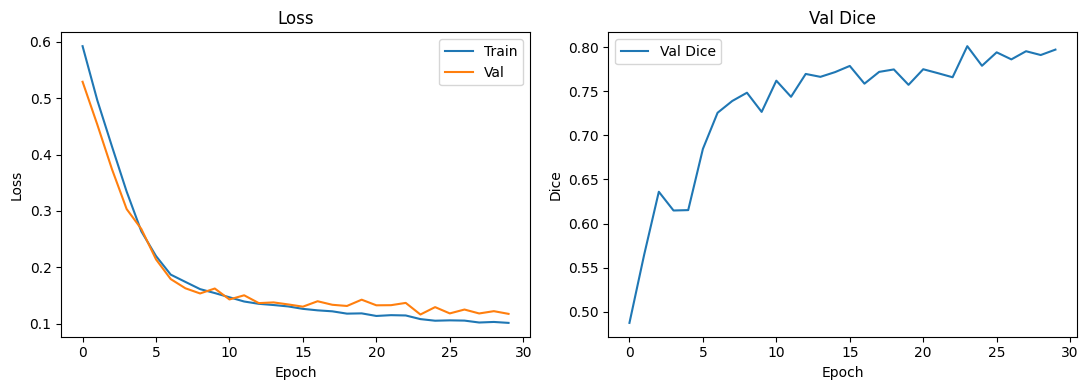

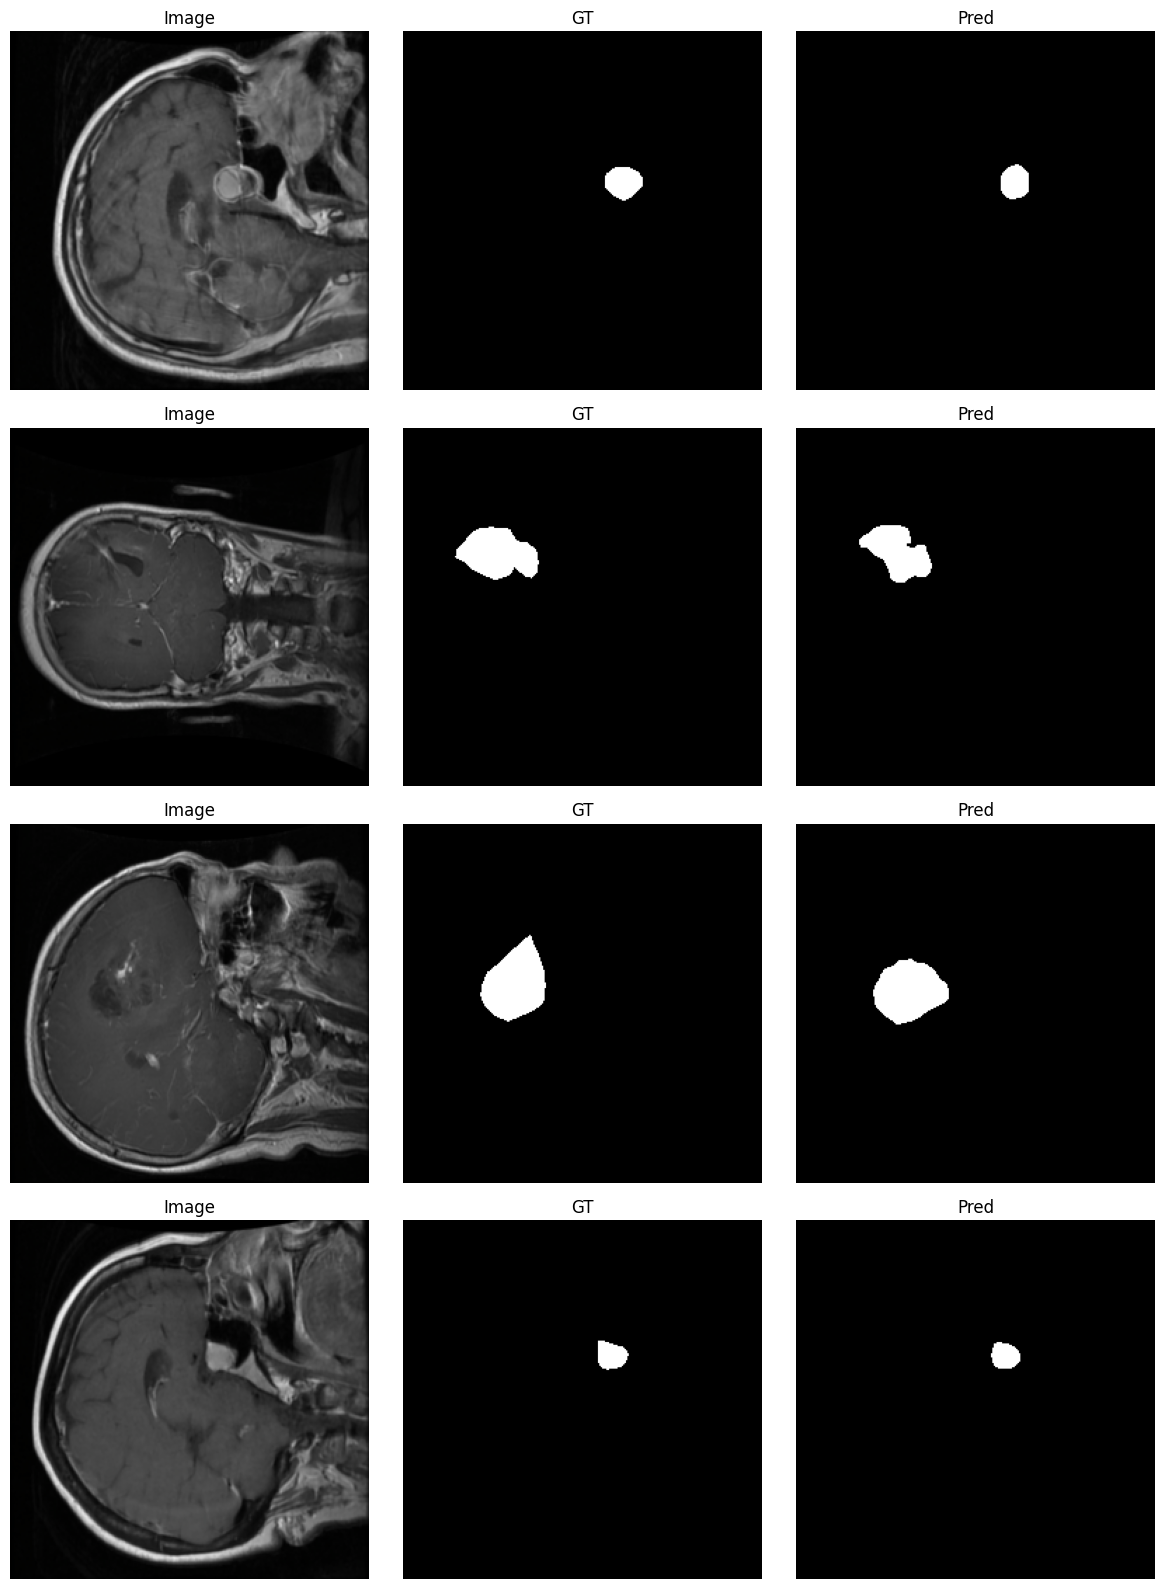

In [2]:
# ============================
# TEACHER: Hybrid U-Net + ViT
# Cross-Architectural KD++ (Teacher training)
# ============================
import os, glob, math, time, random, warnings
import numpy as np
import h5py
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.functional as TF
from torchvision import models

warnings.filterwarnings("ignore")

# --------------------------
# Reproducibility
# --------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# --------------------------
# Device Setup (with AMP)
# --------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
print("Using device:", device)
if device.type == "cuda":
    gpu_props = torch.cuda.get_device_properties(0)
    print("GPU:", torch.cuda.get_device_name(0), "| VRAM: {:.2f} GB".format(gpu_props.total_memory/1024**3))

# --------------------------
# Utility: Load MATLAB file
# --------------------------
def load_matlab_file(file_path):
    with h5py.File(file_path, 'r') as f:
        if "cjdata" in f:
            g = f["cjdata"]
            data = {k: g[k][()] for k in g.keys()}
        else:
            data = {k: f[k][()] for k in f.keys()}
    return data

# --------------------------
# Data Augmentation / Preproc
# --------------------------
def random_intensity_jitter(img):
    # simple brightness/contrast jitter
    if np.random.rand() < 0.5:
        factor = 0.9 + 0.2*np.random.rand()
        img = TF.adjust_brightness(img, factor)
    if np.random.rand() < 0.5:
        factor = 0.9 + 0.2*np.random.rand()
        img = TF.adjust_contrast(img, factor)
    return img

def seg_transform(image, mask, is_train=True, target_size=(256,256)):
    # Resize
    image = TF.resize(image, target_size)
    mask  = TF.resize(mask, target_size, interpolation=Image.NEAREST)
    if is_train:
        # Geometric
        if np.random.rand() < 0.5:
            image = TF.hflip(image); mask = TF.hflip(mask)
        if np.random.rand() < 0.2:
            angle = np.random.uniform(-10, 10)
            image = TF.rotate(image, angle, interpolation=Image.BILINEAR, expand=False)
            mask  = TF.rotate(mask, angle, interpolation=Image.NEAREST,  expand=False)
        # Photometric
        image = random_intensity_jitter(image)

    # To tensor + norm
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])

    # Mask to tensor [0,1]
    mask = np.array(mask, dtype=np.uint8)
    if mask.max() > 1: mask = mask/255.0
    mask = torch.from_numpy(mask).float().unsqueeze(0)
    return image, mask

# --------------------------
# Dataset
# --------------------------
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, file_list, is_train=True):
        self.file_list = file_list
        self.is_train = is_train

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        data = load_matlab_file(file_path)

        # Image
        if "image" not in data:
            raise KeyError(f"'image' not found in file: {file_path}")
        img = data["image"]
        img = np.array(img)
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        img = img.astype(np.float32)
        # robust min-max
        imin, imax = np.min(img), np.max(img)
        if imax-imin > 1e-6:
            img = (img - imin)/(imax-imin)
        img = (img*255.0).clip(0,255).astype(np.uint8)
        image = Image.fromarray(img)

        # Mask
        if "tumorMask" in data and data["tumorMask"] is not None:
            m = np.array(data["tumorMask"])
            if m.ndim>2: m = np.squeeze(m)
            m = (m>0).astype(np.uint8)*255
            mask = Image.fromarray(m)
        elif "tumorBorder" in data and data["tumorBorder"] is not None:
            mask = Image.new("L", image.size, 0)
            draw = ImageDraw.Draw(mask)
            pts = list(np.squeeze(data["tumorBorder"]))
            pts = [(int(pts[i]), int(pts[i+1])) for i in range(0, len(pts), 2)]
            draw.polygon(pts, outline=1, fill=1)
            mask = mask.convert("L")
        else:
            raise ValueError("No tumorMask or tumorBorder in: " + file_path)

        image, mask = seg_transform(image, mask, is_train=self.is_train)
        return image, mask

# --------------------------
# Data paths
# --------------------------
# If you used kagglehub earlier, point to that cache:
dataset_dir = "/root/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1"
all_files = glob.glob(os.path.join(dataset_dir, "**", "*.mat"), recursive=True)
all_files = [f for f in all_files if "cvind" not in os.path.basename(f).lower()]
print("Total .mat:", len(all_files))
np.random.shuffle(all_files)
split = int(0.8*len(all_files))
train_files, val_files = all_files[:split], all_files[split:]
print("Train:", len(train_files), "| Val:", len(val_files))

train_ds = BrainTumorSegmentationDataset(train_files, True)
val_ds   = BrainTumorSegmentationDataset(val_files,   False)

batch_size = 8
num_workers = 4 if torch.cuda.is_available() else 0
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# --------------------------
# U-Net blocks
# --------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2)-x1.size(2); diffX = x2.size(3)-x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# --------------------------
# Hybrid Teacher Model
# --------------------------
def get_vit():
    # compatibility across torchvision versions
    try:
        vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
    except Exception:
        vit = models.vit_b_16(pretrained=True)
    vit.heads = nn.Identity()
    return vit

class HybridTeacherModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, bilinear=True):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128);        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256);       self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512);       self.pool4 = nn.MaxPool2d(2)
        self.bridge = DoubleConv(512, 1024)

        self.vit = get_vit()
        self.vit_proj = nn.Linear(768, 1024)

        self.up4 = Up(1024+512, 512, bilinear)
        self.up3 = Up(512+256, 256, bilinear)
        self.up2 = Up(256+128, 128, bilinear)
        self.up1 = Up(128+64,  64,  bilinear)
        self.outc = nn.Conv2d(64, num_classes, 1)

    def forward(self, x, return_features=False):
        x1 = self.enc1(x); x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2)); x4 = self.enc4(self.pool3(x3))
        xb = self.bridge(self.pool4(x4))

        vit_in = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=True)
        vit_feat = self.vit(vit_in)              # [B, 768]
        vit_feat = self.vit_proj(vit_feat)       # [B, 1024]
        vit_feat = vit_feat[:, :, None, None].expand_as(xb)
        xb = xb + vit_feat                        # fuse

        d4 = self.up4(xb, x4)
        d3 = self.up3(d4, x3)
        d2 = self.up2(d3, x2)
        d1 = self.up1(d2, x1)
        logits = self.outc(d1)

        if return_features:
            return logits, {"d4": d4, "d3": d3, "d2": d2, "d1": d1, "logits": logits}
        return logits

# --------------------------
# Losses & Metrics
# --------------------------
class DiceLoss(nn.Module):
    def __init__(self, eps=1.0):
        super().__init__(); self.eps=eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2*(probs*targets).sum(dim=(1,2,3)) + self.eps
        den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.eps
        return 1 - (num/den).mean()

def dice_coeff_from_logits(logits, targets, thr=0.5, eps=1.0):
    preds = (torch.sigmoid(logits) > thr).float()
    inter = (preds*targets).sum(dim=(1,2,3))
    den = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    return ((2*inter + eps)/(den + eps)).mean()

# --------------------------
# Train
# --------------------------
teacher = HybridTeacherModel().to(device)
optimizer = optim.AdamW(teacher.parameters(), lr=1e-4, weight_decay=1e-4)
bce = nn.BCEWithLogitsLoss()
dice = DiceLoss()

best_val, patience, patience_ctr = -1.0, 8, 0
num_epochs = 30
train_losses, val_losses, val_dices = [], [], []

print("\n--- Training Teacher Model (BCE + Dice) ---")
for epoch in range(1, num_epochs+1):
    teacher.train()
    epoch_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = teacher(images)
            loss = 0.5*bce(logits, masks) + 0.5*dice(logits, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        epoch_loss += loss.item()*images.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    teacher.eval()
    vloss, vdice = 0.0, 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            logits = teacher(images)
            loss = 0.5*bce(logits, masks) + 0.5*dice(logits, masks)
            vloss += loss.item()*images.size(0)
            vdice += dice_coeff_from_logits(logits, masks).item()*images.size(0)
    vloss /= len(val_loader.dataset)
    vdice /= len(val_loader.dataset)
    val_losses.append(vloss); val_dices.append(vdice)

    print(f"Epoch [{epoch:02d}/{num_epochs}] TrainLoss {epoch_loss:.4f} | ValLoss {vloss:.4f} | ValDice {vdice:.4f}")

    # Early stopping on Dice
    if vdice > best_val + 1e-4:
        best_val = vdice; patience_ctr = 0
        torch.save(teacher.state_dict(), "teacher_hybrid_unet_vit_seg.pth")
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping triggered.")
            break

print(f"Best Val Dice: {best_val:.4f} | Saved: teacher_hybrid_unet_vit_seg.pth")

# --------------------------
# Quick curves
# --------------------------
plt.figure(figsize=(11,4))
plt.subplot(1,2,1); plt.plot(train_losses, label="Train"); plt.plot(val_losses, label="Val")
plt.title("Loss"); plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.subplot(1,2,2); plt.plot(val_dices, label="Val Dice")
plt.title("Val Dice"); plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Dice")
plt.tight_layout(); plt.show()

# --------------------------
# Sample preds
# --------------------------
teacher.eval()
sample_loader = DataLoader(val_ds, batch_size=4, shuffle=True)
images, masks = next(iter(sample_loader))
images = images.to(device)
with torch.no_grad():
    logits = teacher(images)
preds = (torch.sigmoid(logits)>0.5).float().cpu()
images = images.cpu()

def inv_normalize(img):
    return torch.clamp(TF.normalize(img, [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                       [1/0.229, 1/0.224, 1/0.225]), 0, 1)

fig, ax = plt.subplots(4,3, figsize=(12,16))
for i in range(4):
    ax[i,0].imshow(inv_normalize(images[i]).permute(1,2,0)); ax[i,0].set_title("Image"); ax[i,0].axis("off")
    ax[i,1].imshow(masks[i].squeeze(0), cmap="gray");         ax[i,1].set_title("GT");    ax[i,1].axis("off")
    ax[i,2].imshow(preds[i].squeeze(0), cmap="gray");         ax[i,2].set_title("Pred");  ax[i,2].axis("off")
plt.tight_layout(); plt.show()


Using device: cuda:0
Train: 2451 | Val: 613

--- Training Student with KD++ (KL+Feature+Attention+Edge) ---
Epoch [01/25] TrainLoss 6.0238 | ValLoss 0.6473 | ValDice 0.4656
Epoch [02/25] TrainLoss 4.4854 | ValLoss 0.5960 | ValDice 0.4817
Epoch [03/25] TrainLoss 3.6563 | ValLoss 0.5382 | ValDice 0.5930
Epoch [04/25] TrainLoss 3.0727 | ValLoss 0.4900 | ValDice 0.6246
Epoch [05/25] TrainLoss 2.5742 | ValLoss 0.4480 | ValDice 0.6375
Epoch [06/25] TrainLoss 2.1481 | ValLoss 0.3988 | ValDice 0.6804
Epoch [07/25] TrainLoss 1.7971 | ValLoss 0.3586 | ValDice 0.6903
Epoch [08/25] TrainLoss 1.5042 | ValLoss 0.3191 | ValDice 0.7112
Epoch [09/25] TrainLoss 1.2623 | ValLoss 0.2761 | ValDice 0.7371
Epoch [10/25] TrainLoss 1.0634 | ValLoss 0.2515 | ValDice 0.7232
Epoch [11/25] TrainLoss 0.9031 | ValLoss 0.2219 | ValDice 0.7480
Epoch [12/25] TrainLoss 0.7840 | ValLoss 0.1969 | ValDice 0.7549
Epoch [13/25] TrainLoss 0.6872 | ValLoss 0.1842 | ValDice 0.7544
Epoch [14/25] TrainLoss 0.6115 | ValLoss 0.1680

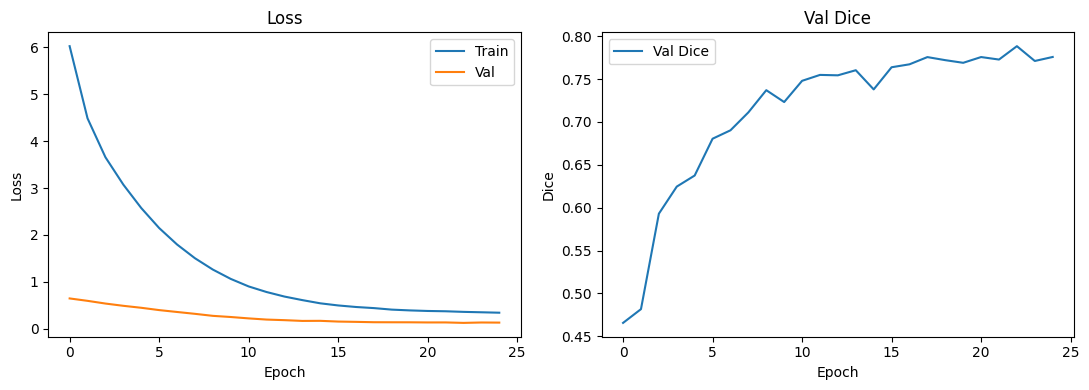

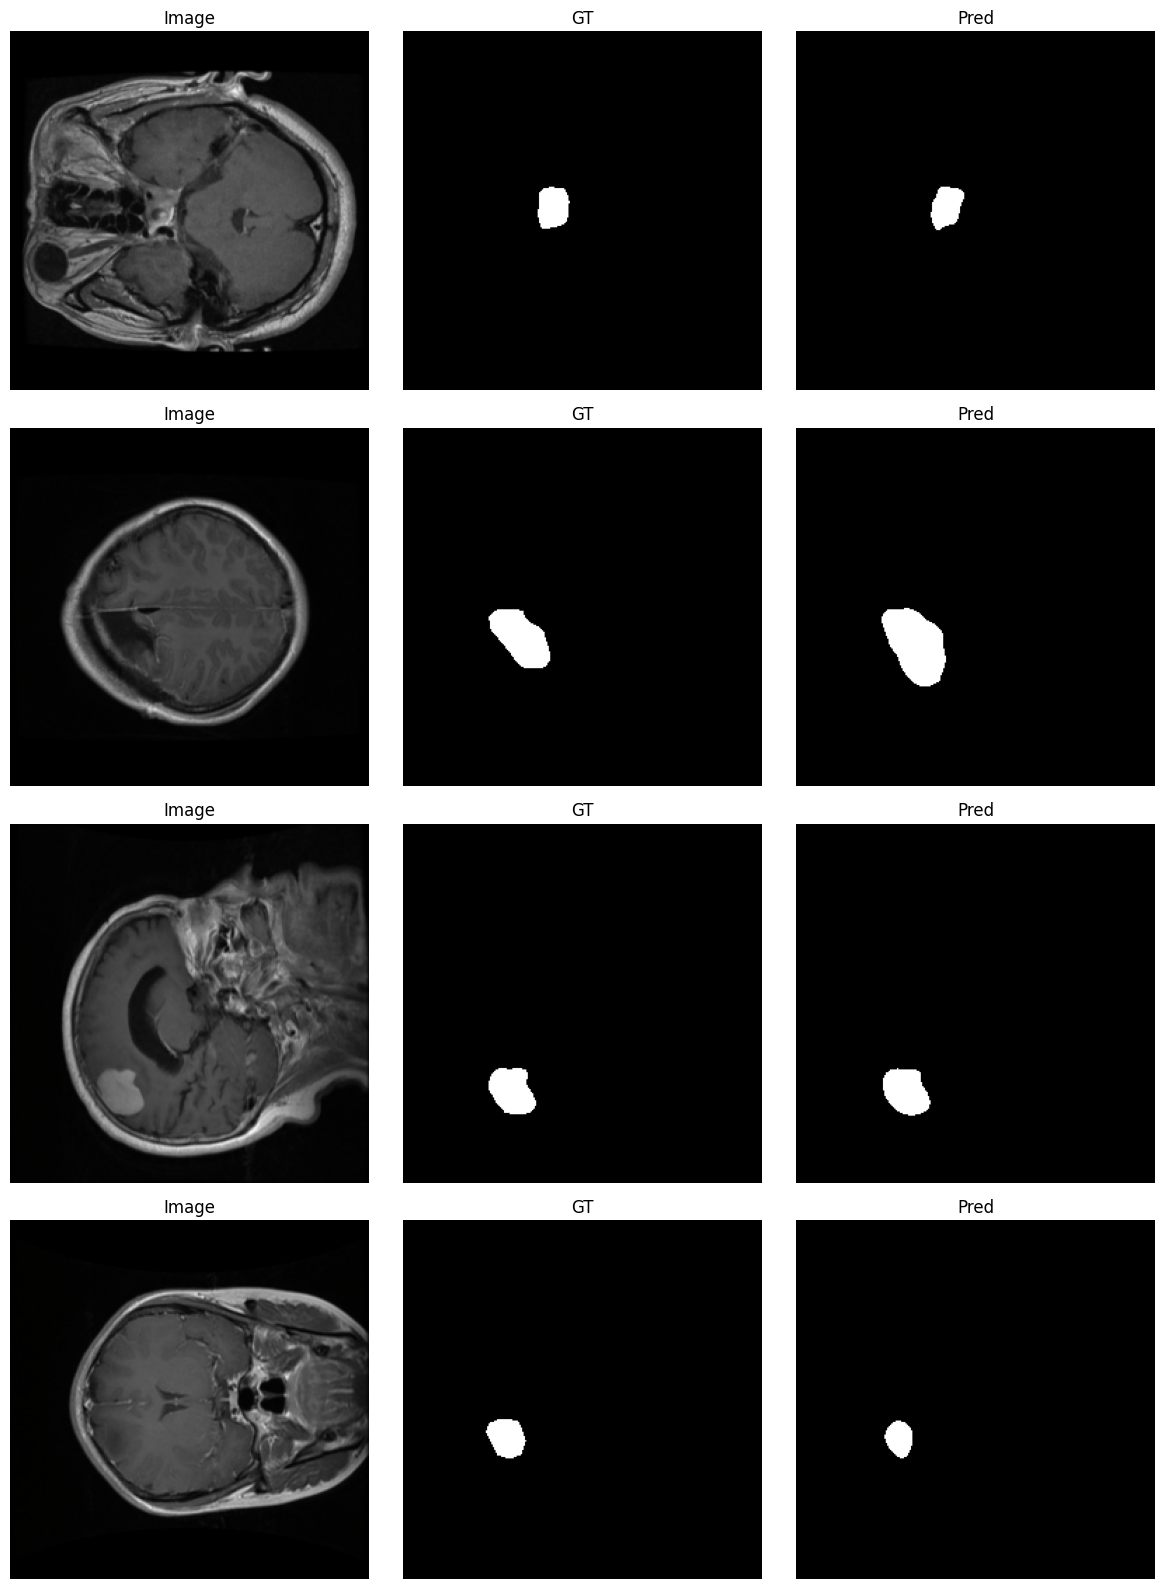

In [4]:
# ============================
# STUDENT: Lightweight U-Net
# Cross-Architectural KD++ (Student distillation)
# ============================
import os, glob, random, warnings
import numpy as np
import h5py
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.functional as TF
from torchvision import models
warnings.filterwarnings("ignore")

# --------------------------
# Reproducibility
# --------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# --------------------------
# Device + AMP
# --------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
print("Using device:", device)

# --------------------------
# Utils: data & aug
# --------------------------
def load_matlab_file(file_path):
    with h5py.File(file_path, 'r') as f:
        if "cjdata" in f:
            g = f["cjdata"]; data = {k: g[k][()] for k in g.keys()}
        else:
            data = {k: f[k][()] for k in f.keys()}
    return data

def random_intensity_jitter(img):
    if np.random.rand() < 0.5:
        img = TF.adjust_brightness(img, 0.9 + 0.2*np.random.rand())
    if np.random.rand() < 0.5:
        img = TF.adjust_contrast(img, 0.9 + 0.2*np.random.rand())
    return img

def seg_transform(image, mask, is_train=True, target_size=(256,256)):
    image = TF.resize(image, target_size)
    mask  = TF.resize(mask, target_size, interpolation=Image.NEAREST)
    if is_train:
        if np.random.rand() < 0.5:
            image = TF.hflip(image); mask = TF.hflip(mask)
        if np.random.rand() < 0.2:
            angle = np.random.uniform(-10, 10)
            image = TF.rotate(image, angle, interpolation=Image.BILINEAR)
            mask  = TF.rotate(mask,  angle, interpolation=Image.NEAREST)
        image = random_intensity_jitter(image)

    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    m = np.array(mask, dtype=np.uint8)
    if m.max()>1: m = m/255.0
    mask = torch.from_numpy(m).float().unsqueeze(0)
    return image, mask

class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, file_list, is_train=True):
        self.file_list = file_list; self.is_train = is_train
    def __len__(self): return len(self.file_list)
    def __getitem__(self, idx):
        fp = self.file_list[idx]; data = load_matlab_file(fp)
        # image
        img = np.array(data["image"])
        if img.ndim==2: img = np.stack([img]*3, axis=-1)
        img = img.astype(np.float32)
        imin, imax = np.min(img), np.max(img)
        if imax-imin > 1e-6: img = (img-imin)/(imax-imin)
        img = (img*255).clip(0,255).astype(np.uint8)
        image = Image.fromarray(img)
        # mask
        if "tumorMask" in data and data["tumorMask"] is not None:
            m = np.array(data["tumorMask"]);
            if m.ndim>2: m = np.squeeze(m)
            m = (m>0).astype(np.uint8)*255
            mask = Image.fromarray(m)
        elif "tumorBorder" in data and data["tumorBorder"] is not None:
            mask = Image.new("L", image.size, 0)
            draw = ImageDraw.Draw(mask)
            pts = list(np.squeeze(data["tumorBorder"]))
            pts = [(int(pts[i]), int(pts[i+1])) for i in range(0,len(pts),2)]
            draw.polygon(pts, outline=1, fill=1); mask = mask.convert("L")
        else:
            raise ValueError("No tumorMask or tumorBorder in: "+fp)
        return seg_transform(image, mask, is_train=self.is_train)

# --------------------------
# Data
# --------------------------
dataset_dir = "/root/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1"
all_files = glob.glob(os.path.join(dataset_dir, "**", "*.mat"), recursive=True)
all_files = [f for f in all_files if "cvind" not in os.path.basename(f).lower()]
np.random.shuffle(all_files)
split = int(0.8*len(all_files))
train_files, val_files = all_files[:split], all_files[split:]
print("Train:", len(train_files), "| Val:", len(val_files))

train_ds = BrainTumorSegmentationDataset(train_files, True)
val_ds   = BrainTumorSegmentationDataset(val_files,   False)
batch_size = 8
num_workers = 4 if torch.cuda.is_available() else 0
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# --------------------------
# Blocks
# --------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2)-x1.size(2); diffX = x2.size(3)-x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        return self.conv(torch.cat([x2, x1], dim=1))

def get_vit():
    try:
        vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
    except Exception:
        vit = models.vit_b_16(pretrained=True)
    vit.heads = nn.Identity()
    return vit

class HybridTeacherModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, bilinear=True):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128);        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256);       self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512);       self.pool4 = nn.MaxPool2d(2)
        self.bridge = DoubleConv(512, 1024)
        self.vit = get_vit(); self.vit_proj = nn.Linear(768, 1024)
        self.up4 = Up(1024+512, 512, bilinear)
        self.up3 = Up(512+256, 256, bilinear)
        self.up2 = Up(256+128, 128, bilinear)
        self.up1 = Up(128+64,  64,  bilinear)
        self.outc = nn.Conv2d(64, num_classes, 1)
    def forward(self, x, return_features=False):
        x1 = self.enc1(x); x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2)); x4 = self.enc4(self.pool3(x3))
        xb = self.bridge(self.pool4(x4))
        vit_in = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=True)
        vit_feat = self.vit(vit_in); vit_feat = self.vit_proj(vit_feat)
        vit_feat = vit_feat[:, :, None, None].expand_as(xb)
        xb = xb + vit_feat
        d4 = self.up4(xb, x4); d3 = self.up3(d4, x3); d2 = self.up2(d3, x2); d1 = self.up1(d2, x1)
        logits = self.outc(d1)
        if return_features:
            return logits, {"d4": d4, "d3": d3, "d2": d2, "d1": d1, "logits": logits}
        return logits

# --------------------------
# Student definition (compact U-Net)
# --------------------------
class StudentUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, bilinear=True):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 32); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(32, 64);         self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(64, 128);        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(128, 256);       self.pool4 = nn.MaxPool2d(2)
        self.bridge = DoubleConv(256, 512)
        self.up4 = Up(512+256, 256, bilinear)
        self.up3 = Up(256+128, 128, bilinear)
        self.up2 = Up(128+ 64,  64, bilinear)
        self.up1 = Up( 64+ 32,  32, bilinear)
        self.outc = nn.Conv2d(32, num_classes, 1)
    def forward(self, x, return_features=False):
        x1 = self.enc1(x); x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2)); x4 = self.enc4(self.pool3(x3))
        xb = self.bridge(self.pool4(x4))
        d4 = self.up4(xb, x4); d3 = self.up3(d4, x3); d2 = self.up2(d3, x2); d1 = self.up1(d2, x1)
        logits = self.outc(d1)
        if return_features:
            return logits, {"d4": d4, "d3": d3, "d2": d2, "d1": d1, "logits": logits}
        return logits

# --------------------------
# Distillation Utilities
# --------------------------
def dice_coeff_from_logits(logits, targets, thr=0.5, eps=1.0):
    preds = (torch.sigmoid(logits) > thr).float()
    inter = (preds*targets).sum(dim=(1,2,3))
    den = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    return ((2*inter + eps)/(den + eps)).mean()

class DiceLoss(nn.Module):
    def __init__(self, eps=1.0):
        super().__init__(); self.eps=eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2*(probs*targets).sum(dim=(1,2,3)) + self.eps
        den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.eps
        return 1 - (num/den).mean()

# Attention map (Zagoruyko & Komodakis, "Paying More Attention...")
def spatial_attention_map(feat, eps=1e-6):
    # feat: [B,C,H,W] -> sum of squares across channels -> normalize per-sample
    att = (feat**2).sum(dim=1, keepdim=True)
    att = att / (att.flatten(2).mean(dim=2, keepdim=True)+eps)  # scale-invariant
    return att

# Sobel edge on logits (encourage sharp boundaries)
def sobel_edges(x):
    # x: [B,1,H,W] logits
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32, device=x.device).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32, device=x.device).view(1,1,3,3)
    gx = F.conv2d(x, kx, padding=1); gy = F.conv2d(x, ky, padding=1)
    mag = torch.sqrt(gx*gx + gy*gy + 1e-6)
    return mag

# --------------------------
# Load Teacher (frozen)
# --------------------------
teacher_ckpt = "teacher_hybrid_unet_vit_seg.pth"  # adjust if stored elsewhere
teacher = HybridTeacherModel().to(device)
teacher.load_state_dict(torch.load(teacher_ckpt, map_location=device))
teacher.eval()
for p in teacher.parameters(): p.requires_grad=False

# --------------------------
# Projections (teacher->student channel align)
# --------------------------
feature_proj = nn.ModuleDict({
    "d4": nn.Conv2d(512, 256, 1),
    "d3": nn.Conv2d(256, 128, 1),
    "d2": nn.Conv2d(128,  64, 1),
    "d1": nn.Conv2d( 64,  32, 1),
}).to(device)

# --------------------------
# Student training setup
# --------------------------
student = StudentUNet().to(device)
optimizer = optim.AdamW(list(student.parameters())+list(feature_proj.parameters()), lr=1e-4, weight_decay=1e-4)
bce = nn.BCEWithLogitsLoss()
dice = DiceLoss()

# KD hyperparams
T = 4.0                          # temperature
alpha = 1.0                      # supervised seg loss weight
beta  = 0.5 * (T*T)              # logit KD (KL) weight; multiply by T^2 per Hinton
gamma = 0.25                     # feature MSE KD
delta = 0.25                     # attention transfer KD
edge_w = 0.2                     # boundary-aware edge loss weight

num_epochs = 25
best_val, patience, patience_ctr = -1.0, 10, 0
train_losses, val_losses, val_dices = [], [], []

print("\n--- Training Student with KD++ (KL+Feature+Attention+Edge) ---")
for epoch in range(1, num_epochs+1):
    student.train()
    epoch_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            t_logits, t_feats = teacher(images, return_features=True)
            t_prob = torch.sigmoid(t_logits)
            # confidence weighting in [0,1]: far from 0.5 -> more confident
            conf_w = (t_prob - 0.5).abs()*2.0

        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            s_logits, s_feats = student(images, return_features=True)

            # 1) Supervised seg loss (BCE + Dice)
            loss_sup = 0.5*bce(s_logits, masks) + 0.5*dice(s_logits, masks)

            # 2) Logit KD (temperature-scaled KL)
            s_soft = torch.log_softmax(s_logits/T, dim=1) if s_logits.size(1)>1 else None
            # for binary, build 2-class logits: [p, 1-p] trick using concatenation
            if s_logits.size(1)==1:
                s2 = torch.cat([s_logits, -s_logits], dim=1)  # shape [B,2,H,W]
                t2 = torch.cat([t_logits, -t_logits], dim=1)
                s_logprob = F.log_softmax(s2/T, dim=1)
                t_prob_T  = F.softmax(t2/T, dim=1)
                # per-pixel KL
                kl = F.kl_div(s_logprob, t_prob_T, reduction='none').sum(dim=1, keepdim=True)
            else:
                # (not used here; we are binary)
                t_prob_T = F.softmax(t_logits/T, dim=1)
                kl = F.kl_div(s_soft, t_prob_T, reduction='none').sum(dim=1, keepdim=True)
            # weight KL by teacher confidence
            kl = (kl * conf_w).mean()

            # 3) Feature KD (multi-scale MSE on aligned channels)
            loss_feat = 0.0
            for k in ["d4","d3","d2","d1"]:
                loss_feat = loss_feat + F.mse_loss(s_feats[k], feature_proj[k](t_feats[k]))

            # 4) Attention Transfer KD
            at_loss = 0.0
            for k in ["d4","d3","d2","d1"]:
                s_att = spatial_attention_map(s_feats[k])
                t_att = spatial_attention_map(feature_proj[k](t_feats[k]))
                at_loss = at_loss + F.mse_loss(s_att, t_att)

            # 5) Boundary-aware edge loss (Sobel on logits vs GT edges)
            s_edge = sobel_edges(s_logits)
            gt_edge = sobel_edges(masks)  # edges from mask (works since mask in [0,1])
            loss_edge = F.l1_loss(s_edge, gt_edge)

            total = alpha*loss_sup + beta*kl + gamma*loss_feat + delta*at_loss + edge_w*loss_edge

        scaler.scale(total).backward()
        scaler.step(optimizer); scaler.update()
        epoch_loss += total.item()*images.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation (supervised metrics only)
    student.eval()
    vloss, vdice = 0.0, 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            logits = student(images)
            loss = 0.5*bce(logits, masks) + 0.5*dice(logits, masks)
            vloss += loss.item()*images.size(0)
            vdice += dice_coeff_from_logits(logits, masks).item()*images.size(0)
    vloss /= len(val_loader.dataset)
    vdice /= len(val_loader.dataset)
    val_losses.append(vloss); val_dices.append(vdice)

    print(f"Epoch [{epoch:02d}/{num_epochs}] TrainLoss {epoch_loss:.4f} | ValLoss {vloss:.4f} | ValDice {vdice:.4f}")

    if vdice > best_val + 1e-4:
        best_val = vdice; patience_ctr = 0
        torch.save(student.state_dict(), "student_unet_distilled_seg.pth")
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping."); break

print(f"Best Val Dice: {best_val:.4f} | Saved: student_unet_distilled_seg.pth")

# --------------------------
# Curves & samples
# --------------------------
plt.figure(figsize=(11,4))
plt.subplot(1,2,1); plt.plot(train_losses, label="Train"); plt.plot(val_losses, label="Val")
plt.title("Loss"); plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.subplot(1,2,2); plt.plot(val_dices, label="Val Dice")
plt.title("Val Dice"); plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Dice")
plt.tight_layout(); plt.show()

student.eval()
sample_loader = DataLoader(val_ds, batch_size=4, shuffle=True)
images, masks = next(iter(sample_loader))
images = images.to(device)
with torch.no_grad():
    logits = student(images)
preds = (torch.sigmoid(logits)>0.5).float().cpu()
images = images.cpu()

def inv_normalize(img):
    return torch.clamp(TF.normalize(img, [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                       [1/0.229, 1/0.224, 1/0.225]), 0, 1)

fig, ax = plt.subplots(4,3, figsize=(12,16))
for i in range(4):
    ax[i,0].imshow(inv_normalize(images[i]).permute(1,2,0)); ax[i,0].set_title("Image"); ax[i,0].axis("off")
    ax[i,1].imshow(masks[i].squeeze(0), cmap="gray");         ax[i,1].set_title("GT");    ax[i,1].axis("off")
    ax[i,2].imshow(preds[i].squeeze(0), cmap="gray");         ax[i,2].set_title("Pred");  ax[i,2].axis("off")
plt.tight_layout(); plt.show()
